# » `Dependencias`:

In [ ]:
# !pip install plotly
# !pip install sqlalchemy
# !pip install numpy
# !pip install matplotlib

In [113]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import re
# import cufflinks as cf
# from IPython.display import display, HTML

# cf.set_config_file

## 1. Conección → SIM(172.27.0.124)

In [114]:
# spring.datasource.url = jdbc:sqlserver://172.27.250.27;databaseName=SIRIM
SERVER = '172.27.0.124'
#DRIVER = 'SQL Server Native Client 11.0'
DRIVER = 'ODBC Driver 17 for SQL Server'
DATABASE = 'SIM'
USERNAME = 'userestadistica'
PASSWORD = '$Us3R_3sT4d1sTic4$'
DATABASE_CONNECTION = f'mssql://{USERNAME}:{PASSWORD}@{SERVER}/{DATABASE}?driver={DRIVER}'

engine = create_engine(DATABASE_CONNECTION)
connection = engine.connect()

## 2. Métodos genérico:

In [115]:
def get_query_sql(query):
  try:
    df = pd.read_sql(query, connection)
    return df
  except:
    print('¡Ocurrió un error!')

## 3. Visualización de datos: `INF-MAR2024`

### 3.1 Calidad solicitada `Trabajador`, no registra `Empresa`.

In [78]:
QUERY_INFO_1 = '''
                  SELECT
                     t.sNumeroTramite,
                     [sTipoTramite] = tt.sSigla,
                     [sCalidad] = cm.sDescripcion,
                     ti.sEstadoActual,
                     [dFechaTramite] = t.dFechaHora,
                     o.nIdOrganizacion,
                     [sOrganización] = o.sNombre
                  FROM SimTramite t
                  JOIN SimTramiteInm ti ON t.sNumeroTramite = ti.sNumeroTramite
                  JOIN SimTipoTramite tt ON t.nIdTipoTramite = tt.nIdTipoTramite
                  LEFT JOIN SimOrganizacion o ON ti.nIdOrganizacion = o.nIdOrganizacion
                  JOIN SimCambioCalMig ccm ON t.sNumeroTramite = ccm.sNumeroTramite
                  JOIN SimCalidadMigratoria cm ON ccm.nIdCalSolicitada = cm.nIdCalidad
                  WHERE
                     t.bCancelado = 0
                     AND ti.sEstadoActual = 'A'
                     AND ccm.nIdCalSolicitada IN (

                        SELECT cm.nIdCalidad
                        FROM SimCalidadMigratoria cm
                        WHERE 
                           cm.bActivo = 1
                           AND cm.sDescripcion LIKE '%trab%'

                     )
'''

df_1 = get_query_sql(QUERY_INFO_1)

<Axes: >

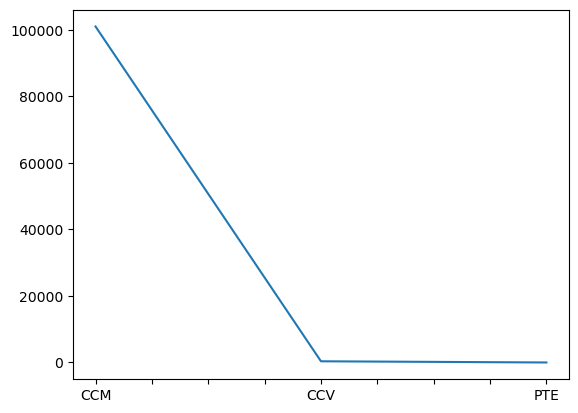

In [33]:
# Méthod's
def get_group_name(value):
   result = 'Registra'
   if pd.isna(value):
     result = 'No registra'
   return result

# ['sNumeroTramite', 'sTipoTramite', 'sEstadoActual', 'dFechaTramite', 'nIdOrganizacion', 'sOrganización'],
df_1['sGrupo'] = df_1['nIdOrganizacion'].apply(get_group_name)
df_1.groupby(by=['sTipoTramite']).agg({ 'sNumeroTramite': [np.ma.count] }).plot(legend=False, xlabel='')


### 3.2 Extranjeros `Regulares` con direcciones incongruentes.

In [107]:
QUERY_INF_2 = '''
                  SELECT
                     [Id Persona] = p.uIdPersona,
                     [Nombres] = p.sNombre,
                     [Apellido 1] = p.sPaterno,
                     [Apellido 2] = p.sMaterno,
                     [Sexo] = p.sSexo,
                     [Fecha de Nacimiento] = p.dFechaNacimiento,
                     [Nacionalidad ] = p.sIdPaisNacionalidad,

                     -- Aux
                     [nÜmero Carnet] = e3.sNumeroCarnet,
                     [Calidad Migratoria] = cm.sDescripcion,
                     [sDireccion] = se.sDomicilio 
                  FROM (

                     SELECT e2.*
                     FROM (

                        SELECT
                           e.*,
                           [nReciente] = ROW_NUMBER() OVER (PARTITION BY e.uIdPersona ORDER BY e.dFechaEmision DESC)
                        FROM (
                           SELECT * FROM tmp_ce
                           UNION ALL
                           SELECT * FROM tmp_ptp
                        ) e

                     ) e2
                     WHERE e2.nReciente = 1

                  ) e3
                  JOIN SimPersona p ON e3.uIdPersona = p.uIdPersona
                  JOIN SimExtranjero se ON p.uIdPersona = se.uIdPersona
                  JOIN SimCalidadMigratoria cm ON p.nIdCalidad = cm.nIdCalidad
'''

df_2 = get_query_sql(QUERY_INF_2)

In [109]:
def get_group_dir(dir):

   result = '@'
   try:
      count_symbol = len(re.findall(r'[^a-zA-Z0-9_\s\-\.]', dir))
      count_an = len(re.findall(r'[a-zA-Z0-9_\s\-\.]', dir))
      len_dir = len(str.strip(dir))

      if (pd.isna(dir)) | (pd.isnull(dir)) | (len_dir == 0):
         result = 'NA'
      elif (len_dir == 1) & (count_an == 1) & (count_symbol == 0):
         result = '1(AlfNum)'
      elif (len_dir >= 2) & (len_dir <= 4) & (count_an >= 2) & (count_an <= 4) & (count_symbol == 0):
         result = '2-4(AlfNum)'
      elif (len_dir == 1) & (count_an == 0) & (count_symbol == 1):
         result = '1(Sym)'
      elif (len_dir >= 2) & (len_dir <= 4) & (count_symbol >= 2) & (count_symbol <= 4) & (count_an == 0):
         result = '2-4(Sym)'
      return result
   except:
      return result

# ['uIdPersona', 'sNombre', 'sPaterno', 'sMaterno', 'sIdPaisNacionalidad', 'sDireccion_SimExt']
df_2['sGrupo'] = df_2['sDireccion'].apply(get_group_dir)

<Axes: >

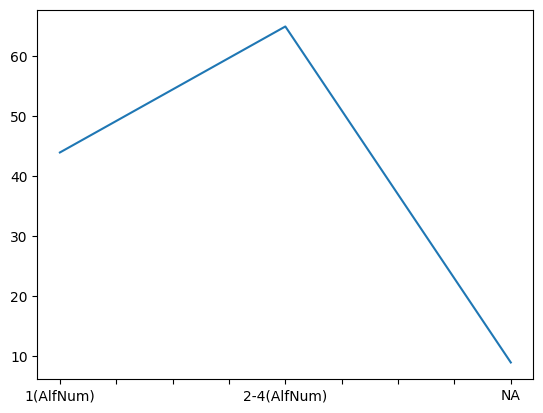

In [111]:
df_2_f = df_2[df_2['sGrupo']!='@']
df_2_f.to_excel('A2.xlsx')
df_2_f.groupby(by=['sGrupo']).agg({ 'Id Persona': [np.ma.count] }).plot(legend=False, xlabel='')



### 3.3 Extranjeros con Calidad Migratoria `TURISTA` sin nacionalidad.

In [119]:
QUERY_INF_3 = '''
                     SELECT

                        [Id Persona] = p.uIdPersona,
                        [Nombres] = p.sNombre,
                        [Apellido 1] = p.sPaterno,
                        [Apellido 2] = p.sMaterno,
                        [Sexo] = p.sSexo,
                        [Fecha de Nacimiento] = p.dFechaNacimiento,
                        [Nacionalidad ] = mm.sIdPaisNacionalidad,

                        -- Aux
                        [Id Mov Migratorio] = mm.sIdMovMigratorio,
                        [Fecha Control] = mm.dFechaControl,
                        [Tipo Movimiento] = mm.sTipo,
                        [Calidad Migratoria] = cm.sDescripcion,
                        [Id Dependencia] = d.sSigla,
                        [Dependencia] = d.sNombre

                     FROM SimMovMigra mm 
                     JOIN SimPersona p ON mm.uIdPersona = p.uIdPersona
                     JOIN SimDependencia d On mm.sIdDependencia = d.sIdDependencia
                     JOIN SimCalidadMigratoria cm ON mm.nIdCalidad = cm.nIdCalidad
                     WHERE
                        mm.bAnulado = 0
                        AND mm.bTemporal = 0
                        -- AND mm.dFechaControl >= '2008-01-01 00:00:00.000'
                        AND mm.nIdCalidad IN ( -- TURISTA
                                                SELECT cm.nIdCalidad 
                                                FROM SimCalidadMigratoria cm 
                                                WHERE 
                                                   cm.bActivo = 1
                                                   AND cm.sDescripcion LIKE '%turi%'
                        )
                        -- AND (p.sIdPaisNacimiento NOT IN ('NNN', 'PER') AND p.sIdPaisNacimiento IS NOT NULL)
                        AND (mm.sIdPaisNacionalidad = 'NNN' OR mm.sIdPaisNacionalidad IS NULL)

'''

df_3 = get_query_sql(QUERY_INF_3)

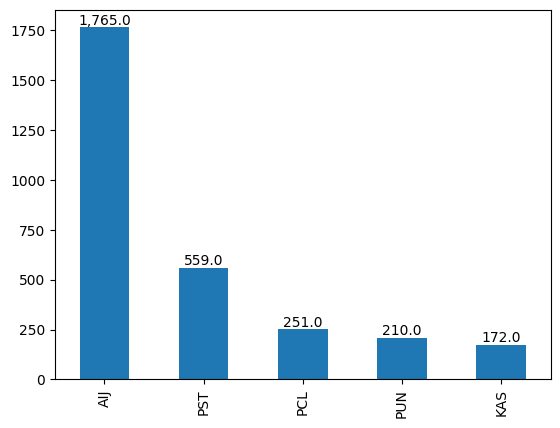

In [140]:
# ['uIdPersona', 'sNombre', 'sPaterno', 'sMaterno', 'sIdPaisNacionalidad', 'sIdModulo']
df_3_f = df_3.groupby(by=['Id Dependencia']).agg({ 'Id Persona': [np.ma.count] }).droplevel(1, axis=1)
df_3_f.rename({ 'Id Persona': 'nContar(Per)' }, axis=1, inplace=True)
df_3_f_g = df_3_f.sort_values(by=['nContar(Per)'], ascending=False).iloc[1:6].plot.bar(legend=False, xlabel='')

# df_3_f_g.bar_label(df_3_f_g.containers[0]) -- Opt 1

for container in df_3_f_g.containers:
   df_3_f_g.bar_label(container, fmt='{:,}') # Opt 2

### 3.4 Ciudadanos con nacionalidad `PERUANA` realizaron control migratorio con mas de 1 documento (DNI).

In [7]:
QUERY_INF_4 = '''
                     SELECT p2.* 
                     FROM (

                        SELECT
                           dp.uIdPersona,
                           dp.sIdDocumento,
                           dp.sNumero,
                           [nCant(Id, DNI, NumDoc)] = COUNT(1) OVER (
                                                            PARTITION BY 
                                                               dp.uIdPersona,
                                                               dp.sIdDocumento,
                                                               dp.sNumero
                                                         ),
                           [nCant(Id, DNI)] = COUNT(1) OVER (
                                                            PARTITION BY 
                                                               dp.uIdPersona,
                                                               dp.sIdDocumento
                                                         )
                        FROM SImDocPersona dp
                        JOIN SimPersona p ON dp.uIdPersona = p.uIdPersona
                        WHERE 
                           (dp.bActivo = 1 AND p.bActivo = 1)
                           AND p.sIdPaisNacionalidad = 'PER'
                           AND dp.sIdDocumento = 'DNI'
                           AND EXISTS (
                                          SELECT TOP 1 1 
                                          FROM SimMovMigra mm
                                          WHERE
                                             mm.bAnulado = 0
                                             AND mm.bTemporal = 0
                                             AND (mm.uIdPersona = dp.uIdPersona AND mm.sIdDocumento = dp.sIdDocumento AND mm.sNumeroDoc = dp.sNumero)
                           )

                     ) p2
                     WHERE
                        p2.[nCant(Id, DNI, NumDoc)] = 1 AND p2.[nCant(Id, DNI)] >= 2

'''

df_4 = get_query_sql(QUERY_INF_4)

In [ ]:
df_4_g1 = df_4.groupby(by=['uIdPersona']).agg({ 'sNumero': [np.ma.count] }).droplevel(0, axis=1).reset_index().rename({ 'count': 'nContar(DNI)' }, axis=1)
df_4_g2 = df_4_g1.groupby(by=['nContar(DNI)']).agg({ 'uIdPersona': [np.ma.count] }).droplevel(0, axis=1).rename({ 'count': 'nContar(Persona)' }, axis=1)

<Axes: >

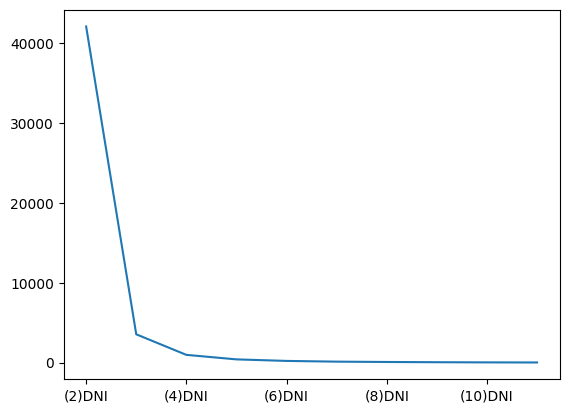

In [69]:
df_4_f_1 = df_4_g2.sort_values(by=['nContar(Persona)'], ascending=False).head(10).reset_index()
df_4_f_1['nContar(DNI)'] = df_4_f_1['nContar(DNI)'].apply(lambda c: f"({c})DNI")
df_4_f_1.set_index('nContar(DNI)', inplace=True)
df_4_f_1.plot(legend=False, xlabel='')

### 3.5 Control Migratorio de ciudadanos con Calidad Migratoria `PERUANO` y tipo de documento de viaje `CIP`.

In [5]:
QUERY_INF_5 = '''
                  SELECT 
                     mm.uIdPersona,
                     mm.dFechaControl,
                     mm.sTipo,
                     [sCalidadMigratoria] = cm.sDescripcion,
                     mm.sIdPaisMov
                  FROM SimMovMigra mm
                  JOIN SimPersona p ON mm.uIdPersona = p.uIdPersona
                  JOIN SimCalidadMigratoria cm ON mm.nIdCalidad = cm.nIdCalidad
                  WHERE
                     mm.bAnulado = 0
                     AND mm.bTemporal = 0
                     -- AND mm.sTipo = 'E'
                     AND mm.sIdDocumento = 'CIP'-- CIP ↔ DOC. IDENTIFICACION PERSONAL
                     AND mm.sIdPaisNacionalidad = 'PER'
                     AND mm.nIdCalidad = 21 -- 21 ↔ PERUANO
'''

df_5 = get_query_sql(QUERY_INF_5)

In [6]:
# Limpieza:
# ['uIdPersona', 'dFechaControl', 'sTipo', 'sCalidadMigratoria', 'sIdPaisMov', 'nAñoControl']
df_5_bak = df_5.copy(deep=False)
df_5_bak['nAñoControl'] = df_5_bak['dFechaControl'].dt.year
df_5_bak['sTipo'] = df_5_bak['sTipo'].astype(str)
df_5_bak['sTipo'] = df_5_bak['sTipo'].str.upper()

df_5_bak_f = df_5_bak.groupby(by=['sIdPaisMov']).agg({ 'uIdPersona': [np.ma.count] }).reset_index()
df_5_bak_f = df_5_bak_f.droplevel(1, axis=1).rename({ 'uIdPersona': 'nCount(Persona)' }, axis=1)

<Axes: >

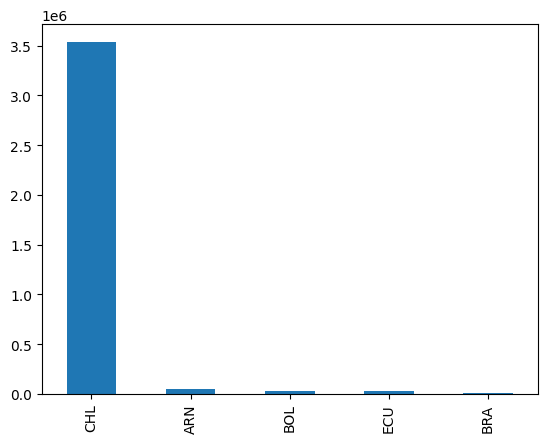

In [13]:
# Vizualización de datos
df_5_bak_f_t5 = df_5_bak_f.sort_values(by=['nCount(Persona)'], ascending=False).head(5)
df_5_bak_f_t5.plot(kind='bar', x='sIdPaisMov', legend=False, xlabel='')